In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

2025-02-07 14:40:32.533591: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 14:40:32.556776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738935632.572760  208208 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738935632.577492  208208 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 14:40:32.601107: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Setup the Data

In [2]:
import pathlib

data_dir = pathlib.Path('data')
print(f"Corrected data directory: {data_dir}")

if data_dir.exists():
    print("Directory exists")
else:
    print("Directory does not exist")

all_files = list(data_dir.glob('**/*'))
print(f"Total files found: {len(all_files)}")

image_files = list(data_dir.glob('**/*.png'))
image_count = len(image_files)
print(f"Total image files found: {image_count}")

Corrected data directory: data
Directory exists
Total files found: 430
Total image files found: 428


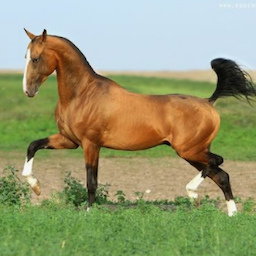

In [3]:
horses = list(data_dir.glob('horse/*'))
PIL.Image.open(str(horses[0]))

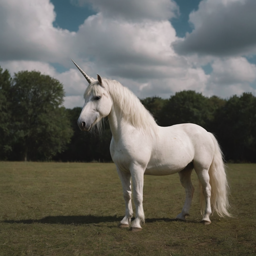

In [4]:
unicorns = list(data_dir.glob('unicorn/*'))
PIL.Image.open(str(unicorns[0]))

# Define parameters

In [5]:
batch_size = 16
img_height = 256
img_width = 256

# Split training and validaiton set

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 428 files belonging to 2 classes.
Using 343 files for training.


I0000 00:00:1738935634.414370  208208 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9502 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 428 files belonging to 2 classes.
Using 85 files for validation.
['horse', 'unicorn']


# Check input data shape

In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 256, 256, 3)
(16,)


# Cache and prefetch the data for more performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Standardize the data

In [9]:
normalization_layer = layers.Rescaling(1./255)

# Make the Model

In [10]:
num_classes = len(class_names)


model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/home/timo/Machine-Learning-WiSe2425/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


I0000 00:00:1738935636.488024  208342 service.cc:148] XLA service 0x7efa400064d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738935636.488067  208342 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-02-07 14:40:36.503006: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738935636.577141  208342 cuda_dnn.cc:529] Loaded cuDNN version 90300


 6/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5356 - loss: 1.1521

I0000 00:00:1738935638.306885  208342 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.6057 - loss: 0.9075 - val_accuracy: 0.9412 - val_loss: 0.2689
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9549 - loss: 0.1966 - val_accuracy: 0.9176 - val_loss: 0.1506
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9877 - loss: 0.0653 - val_accuracy: 0.9529 - val_loss: 0.1089
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9823 - loss: 0.0628 - val_accuracy: 0.9647 - val_loss: 0.0640
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0111 - val_accuracy: 0.9647 - val_loss: 0.0766
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 0.9765 - val_loss: 0.0615
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9882 - val_loss: 0.0502
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9294 - val_loss: 0

# Visualize training results

In [13]:
def show_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    
    plt.show()


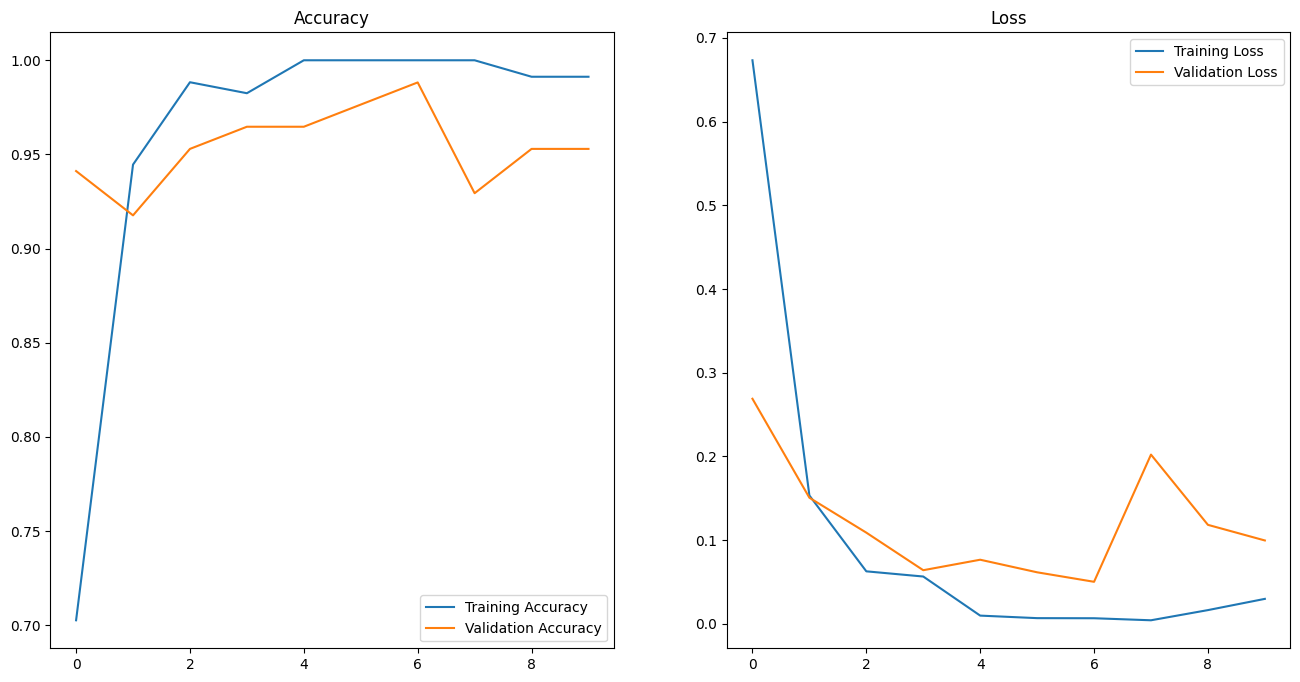

In [14]:
show_results(history)

# Avoid Overfitting

Adding Data augmentaiton, Dropout and early stopping

2025-02-07 14:40:43.794475: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


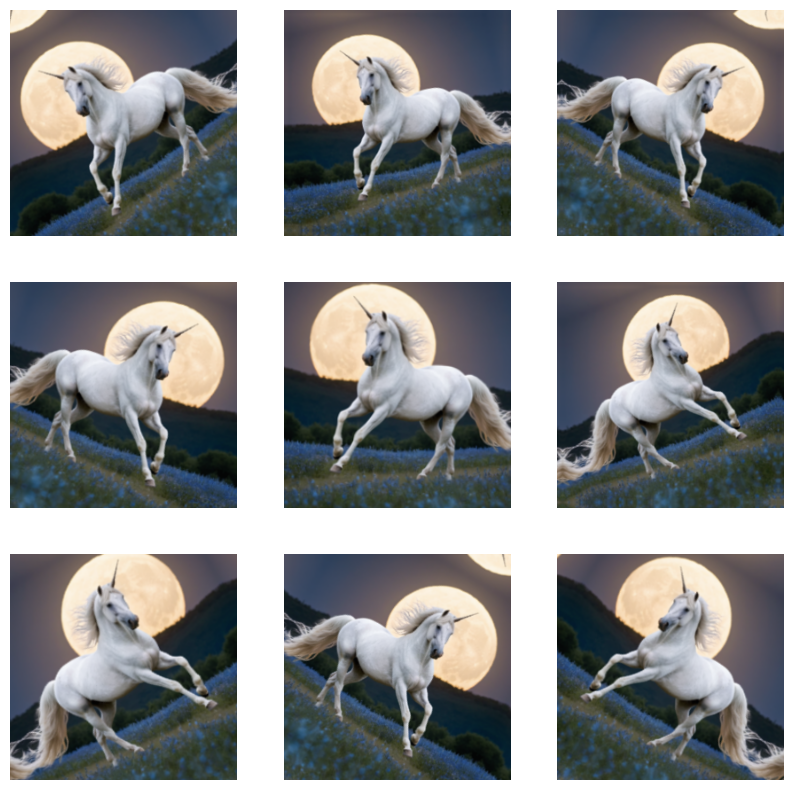

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Epoch 1/25


E0000 00:00:1738935644.715856  208208 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5813 - loss: 0.9336 - val_accuracy: 0.8824 - val_loss: 0.3771
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8425 - loss: 0.4273 - val_accuracy: 0.8824 - val_loss: 0.2664
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9233 - loss: 0.2546 - val_accuracy: 0.9647 - val_loss: 0.0957
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9579 - loss: 0.1261 - val_accuracy: 0.9647 - val_loss: 0.1111
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9667 - loss: 0.1035 - val_accuracy: 0.9765 - val_loss: 0.0760
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9761 - loss: 0.0883 - val_accuracy: 0.9882 - val_loss: 0.0470
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9777 - loss: 0.0667 - val_accuracy: 0.9412 - val_loss: 0.1635
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9280 - loss: 0.1841 - val_accuracy: 0.9882 - val_loss: 0.

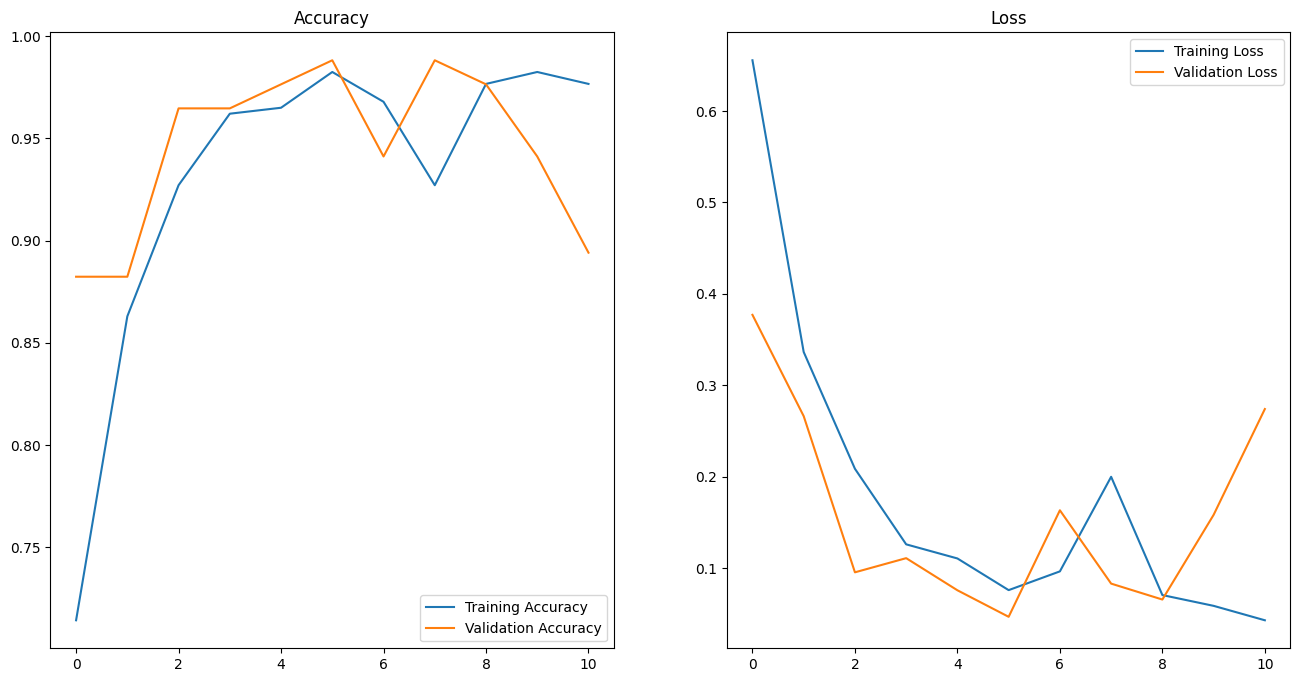

In [16]:
# Bestes Modell

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

show_results(history)


# Refining the Model

Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6226 - loss: 0.8996 - val_accuracy: 0.9294 - val_loss: 0.3858
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9097 - loss: 0.3180 - val_accuracy: 0.9294 - val_loss: 0.2772
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9063 - loss: 0.2487 - val_accuracy: 0.9412 - val_loss: 0.1427
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9514 - loss: 0.1266 - val_accuracy: 0.9529 - val_loss: 0.1388
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9690 - loss: 0.1200 - val_accuracy: 0.9647 - val_loss: 0.0851
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9512 - loss: 0.1542 - val_accuracy: 0.9647 - val_loss: 0.1352
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9740 - loss: 0.0673 - val_accuracy: 0.9647 - val_loss: 0.0584
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9318 - loss: 0.1538 - val_accuracy: 0.9647 - v

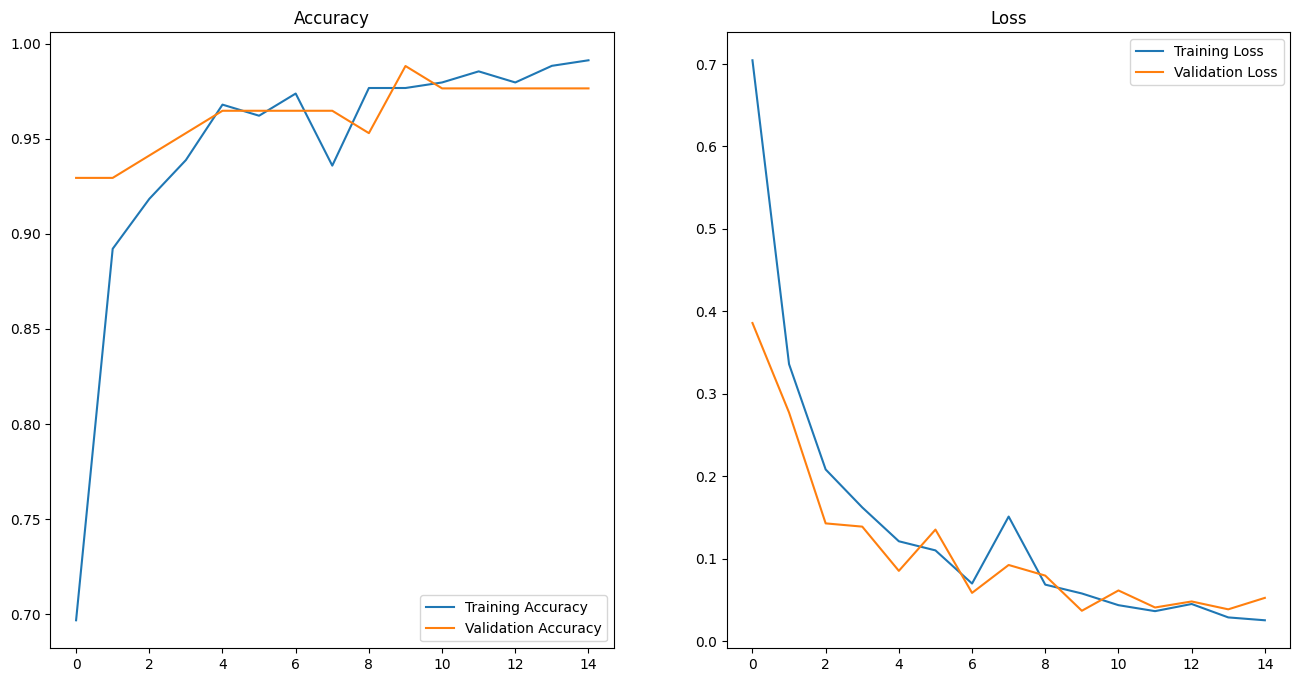

In [17]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

show_results(history)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6269 - loss: 0.8554 - val_accuracy: 0.8588 - val_loss: 0.3165
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8855 - loss: 0.2883 - val_accuracy: 0.9412 - val_loss: 0.1379
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9490 - loss: 0.1546 - val_accuracy: 0.9412 - val_loss: 0.1390
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9646 - loss: 0.0987 - val_accuracy: 0.9529 - val_loss: 0.0795
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9763 - loss: 0.0705 - val_accuracy: 0.9882 - val_loss: 0.0743
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9759 - loss: 0.1147 - val_accuracy: 0.9765 - val_loss: 0.0860
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9791 - loss: 0.0568 - val_accuracy: 0.9412 - val_loss: 0.1561
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9532 - loss: 0.1040 - val_accuracy: 0.9647 - v

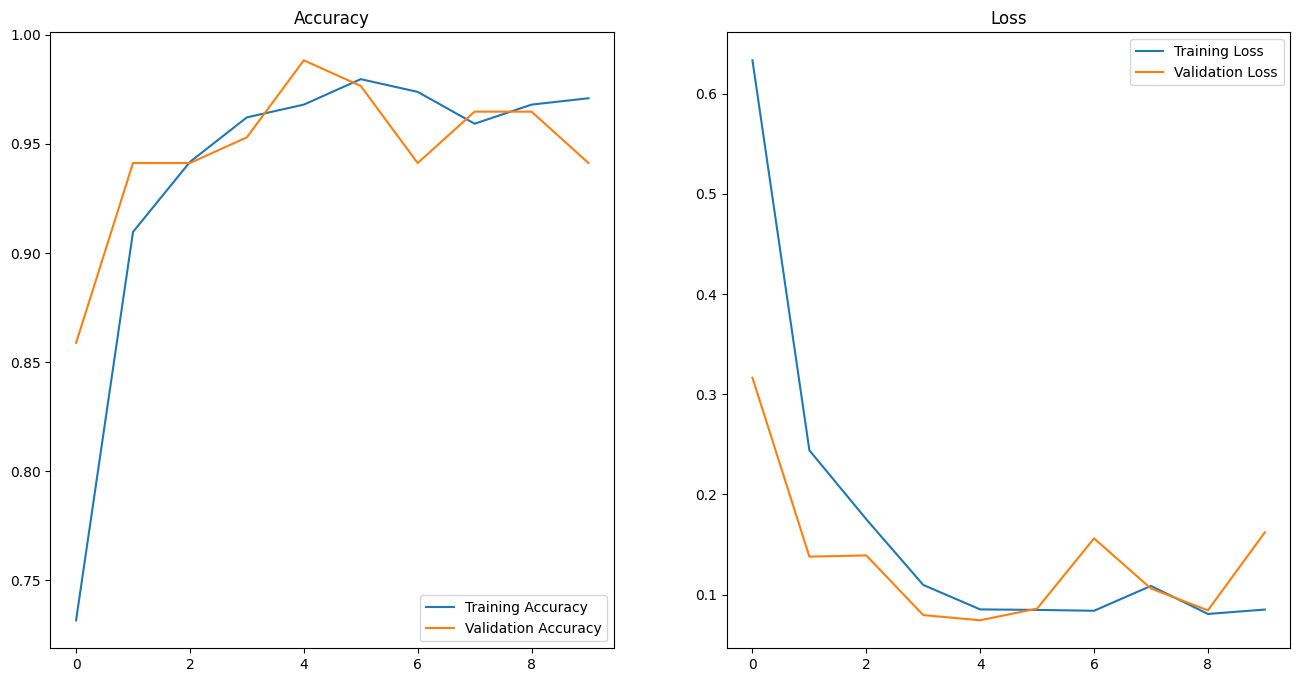

In [18]:


model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

show_results(history)

Make the Convolution and Pooling smaller

Epoch 1/50


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5060 - loss: 0.7112 - val_accuracy: 0.9059 - val_loss: 0.4512
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9281 - loss: 0.3347 - val_accuracy: 0.9294 - val_loss: 0.2171
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9134 - loss: 0.2263 - val_accuracy: 0.9294 - val_loss: 0.2003
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9427 - loss: 0.1680 - val_accuracy: 0.9294 - val_loss: 0.1861
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9569 - loss: 0.1143 - val_accuracy: 0.9412 - val_loss: 0.1673
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9833 - loss: 0.0717 - val_accuracy: 0.9176 - val_loss: 0.1674
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9644 - loss: 0.0690 - val_accuracy: 0.9529 - val_loss: 0.1078
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9845 - loss: 0.0771 - val_accuracy: 0.9294 - val_loss: 0.

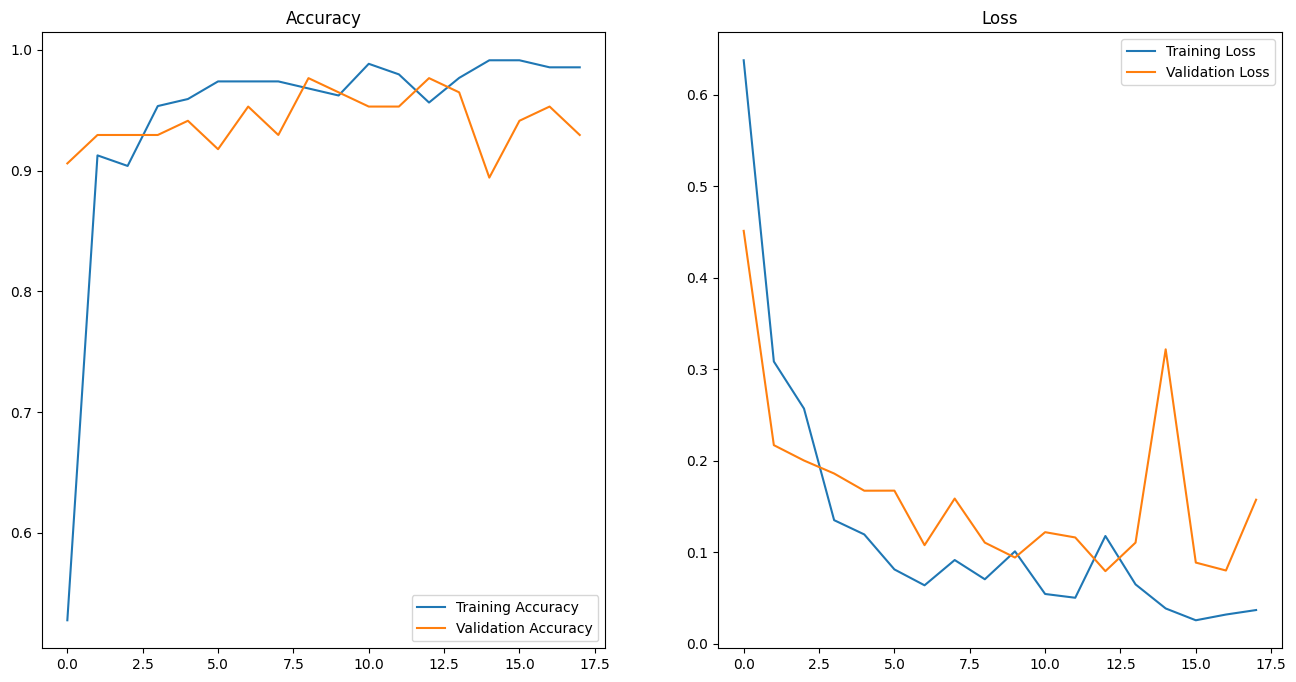

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

show_results(history)

change batch size

Found 428 files belonging to 2 classes.


Using 343 files for training.
Found 428 files belonging to 2 classes.
Using 85 files for validation.
['horse', 'unicorn']
Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4962 - loss: 0.7021 - val_accuracy: 0.6353 - val_loss: 0.5876
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8321 - loss: 0.5018 - val_accuracy: 0.8118 - val_loss: 0.5718
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8198 - loss: 0.5337 - val_accuracy: 0.8235 - val_loss: 0.5618
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8903 - loss: 0.4409 - val_accuracy: 0.9294 - val_loss: 0.3827
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9171 - loss: 0.3634 - val_accuracy: 0.9176 - val_loss: 0.2953
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9142 - loss: 0.2960 - val_accuracy: 0.9294 - val_loss: 0.2229
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9508 - loss: 0.2049 - val_accuracy: 0.8706 - val_los

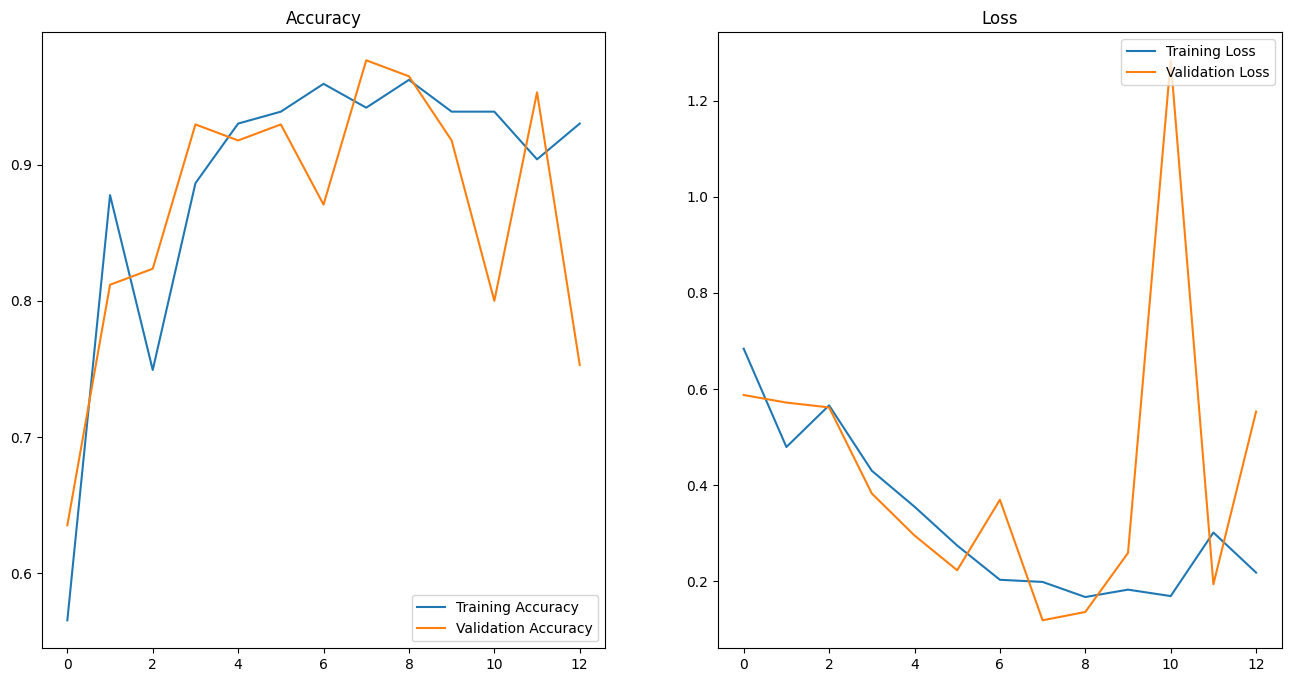

In [20]:
batch_size = 4
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

show_results(history)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5152 - loss: 0.7292 - val_accuracy: 0.7059 - val_loss: 0.6413
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8558 - loss: 0.3326 - val_accuracy: 0.8941 - val_loss: 0.3021
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8882 - loss: 0.2888 - val_accuracy: 0.9176 - val_loss: 0.1934
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9105 - loss: 0.2145 - val_accuracy: 0.9176 - val_loss: 0.2704
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9391 - loss: 0.1789 - val_accuracy: 0.9647 - val_loss: 0.1297
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9217 - loss: 0.2732 - val_accuracy: 0.9647 - val_loss: 0.1502
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9498 - loss: 0.1498 - val_accuracy: 0.9647 - val_loss: 0.0719
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9446 - loss: 0.1514 - val_accuracy: 0.9529 - v

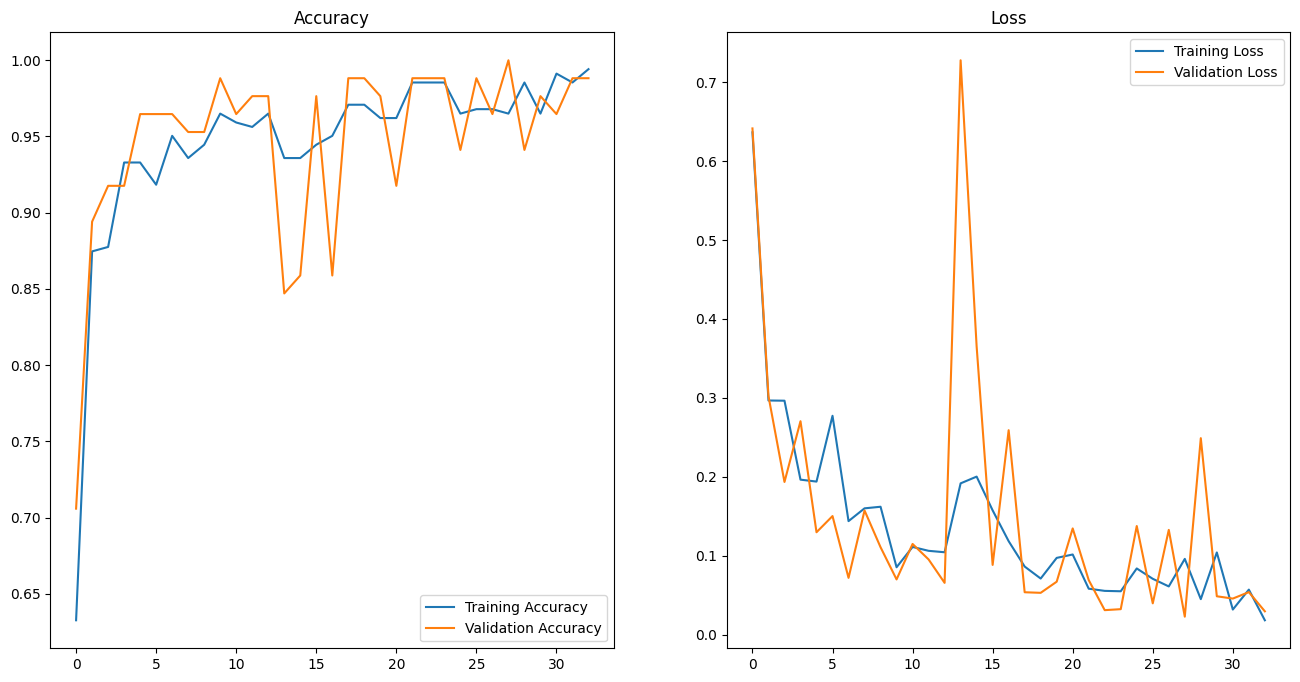

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

show_results(history)

Epoch 1/50


E0000 00:00:1738935717.045058  208208 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_8_1/dropout_6_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6859 - loss: 0.6244 - val_accuracy: 0.8941 - val_loss: 0.3308
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8842 - loss: 0.4409 - val_accuracy: 0.8824 - val_loss: 0.3237
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8965 - loss: 0.2437 - val_accuracy: 0.9294 - val_loss: 0.2303
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9094 - loss: 0.2693 - val_accuracy: 0.9647 - val_loss: 0.1415
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9280 - loss: 0.2137 - val_accuracy: 0.9529 - val_loss: 0.1357
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9473 - loss: 0.1304 - val_accuracy: 0.9765 - val_loss: 0.1620
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9603 - loss: 0.1043 - val_accuracy: 0.9647 - val_loss: 0.1330
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9201 - loss: 0.2137 - val_accuracy: 0.8706 - val_loss: 0.

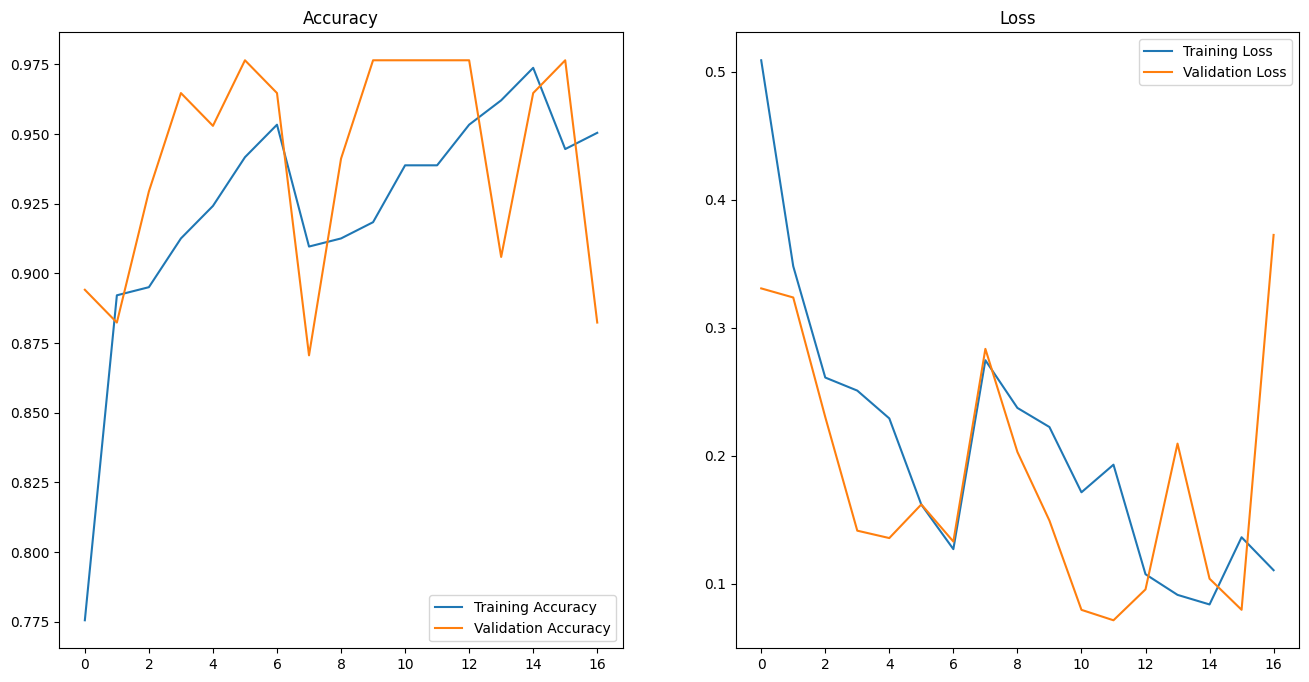

In [22]:

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, activation='relu'),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

show_results(history)

# Predicting o new data

In [23]:
# model.predict